In [1]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)

Attaching SeuratObject

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [2]:
datasetName = 'ovary_ovary_HCLFetalFemaleGonad1'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/db_v1/ovary_ovary_HCLFetalFemaleGonad1/")

In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"), h = T, row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [4]:
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,FetalFemaleGonad_1.CTCGCAGGGTTTTAAGGG,FetalFemaleGonad_1.ACGTTGTGCGGAATTCCA,FetalFemaleGonad_1.CAACAAAACCTACCAGAC,FetalFemaleGonad_1.GCTCAAAACGCCAACCTA,FetalFemaleGonad_1.CGCTTGAGATGGGCTGTG
,<int>,<int>,<int>,<int>,<int>
A1BG,0,0,0,0,0
A1BG-AS1,0,0,0,0,0
A1CF,0,0,0,0,0
A2M,0,0,1,0,0
A2M-AS1,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<chr>,<chr>,<lgl>,<chr>,<int>,<chr>,<chr>
FetalFemaleGonad_1.AAAACGAAGTACGGACAT,Gonad,Gonad,NA,normal,7,Female,26W
FetalFemaleGonad_1.AAAACGATTCCATGTGCG,Gonad,Gonad,NA,normal,1,Female,26W
FetalFemaleGonad_1.AAAACGCAAAGTCTCGCA,Gonad,Gonad,NA,normal,4,Female,26W
FetalFemaleGonad_1.AAAACGCAAAGTTAAGGG,Gonad,Gonad,NA,normal,2,Female,26W
FetalFemaleGonad_1.AAAACGCCGCTAAAGTAC,Gonad,Gonad,NA,normal,2,Female,26W


[1] "Conventional dendritic cell" "Fibroblast"                 
[3] "Smooth muscle cell"          "Epithelial cell"            
[5] "Epithelial cell"

In [5]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message in CreateSeuratObject.default(counts = data.matrix, project = datasetName, :
“Some cells in meta.data not present in provided counts matrix”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


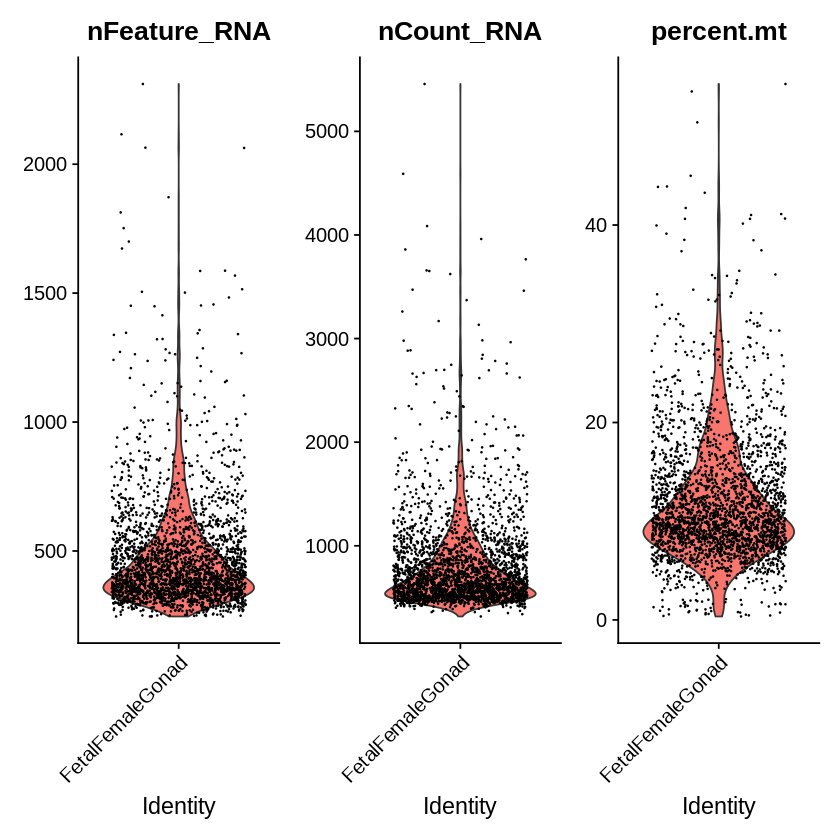

In [6]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [9]:
# QC
nFeature_RNA_range = c(0, 1000)
percent.mt.thre = 30
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [10]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [11]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  SPARC, COL1A2, DCN, COL1A1, COL3A1, SERPINE2, UCHL1, HES1, PDCD5, DLK1 
	   PADI6, TPM1, FIGLA, REXO2, OLFML3, EPCAM, ACTA2, IGFBP5, ZP3, TPM2 
	   PRDX2, SCGB3A2, FOXR1, GTSF1, NLRP5, OOEP, WFDC2, C7, FAM213A, REC114 
Negative:  TYROBP, SRGN, AIF1, HLA-DPA1, MS4A6A, HLA-DRB1, IL1B, HLA-DRA, FCER1G, HLA-DPB1 
	   RGS1, CD74, CXCL8, LAPTM5, CD14, CCL3L3, C1QA, C1QB, CCL3, HLA-DRB6 
	   C1QC, C1orf162, PLAUR, HLA-DQB1, LSP1, GPR183, HCST, CST3, CSF1R, FPR1 
PC_ 2 
Positive:  MT-RNR2, MT-RNR1, FOS, TMSB4X, HES1, SPARC, B2M, IGFBP7, DCN, COL1A2 
	   FOSB, COL3A1, ID3, COL1A1, IFITM2, LGALS1, SPARCL1, ZFP36, TIMP1, CAV1 
	   DUSP1, DNAJB1, RNASE1, TM4SF1, FN1, CCL2, ACTA2, TPM2, OLFML3, ADAMTS1 
Negative:  ZP3, DPPA3, NLRP5, PADI6, STAG3, MRVI1-AS1, UCHL1, KCNQ1-AS1, SCGB3A2, KPNA7 
	   FIGLA, REC114, FAM167A-AS1, FOXR1, C6orf52, OOEP, TUBB8P7, EPCAM, TUBB7P, GTSF1 
	   ATG7, UNC13C, BAIAP2L1, CTRB2, JAZF1, ZFAND2A, LINC01511, OOSP2, PDCD5, LDHAL6A 
PC_ 3 
Positive:  DCN, 

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


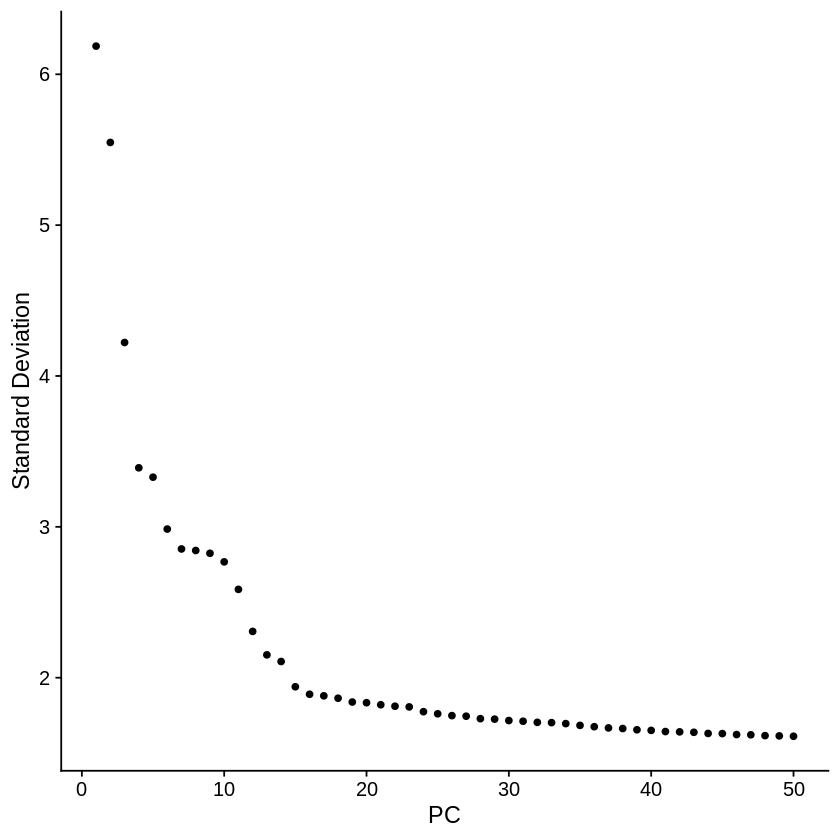

In [12]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [13]:
dev.off()
pcDim = 14 # set as 14 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
18:12:34 UMAP embedding parameters a = 0.9922 b = 1.112

18:12:34 Read 2589 rows and found 14 numeric columns

18:12:34 Using Annoy for neighbor search, n_neighbors = 30

18:12:34 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:12:35 Writing NN index file to temp file /tmp/Rtmp2NeoYD/file557a1f330d60

18:12:35 Searching Annoy index using 1 thread, search_k = 3000

18:12:35 Annoy recall = 100%

18:12:36 Commencing smooth kNN distance calibration using 1 thread

18:12:36 Initializing fro

In [20]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.3)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2589
Number of edges: 92949

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9275
Number of communities: 9
Elapsed time: 0 seconds


18:14:38 UMAP embedding parameters a = 0.9922 b = 1.112

18:14:38 Read 2589 rows and found 14 numeric columns

18:14:38 Using Annoy for neighbor search, n_neighbors = 30

18:14:38 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

18:14:38 Writing NN index file to temp file /tmp/Rtmp2NeoYD/file557a2fd0d272

18:14:38 Searching Annoy index using 1 thread, search_k = 3000

18:14:39 Annoy recall = 100%

18:14:39 Commencing smooth kNN distance calibration using 1 thread

18:14:40 Initializing from normalized Laplacian + noise

18:14:40 Commencing optimization for 500 epochs, with 109846 positive edges

18:14:46 Optimization finished



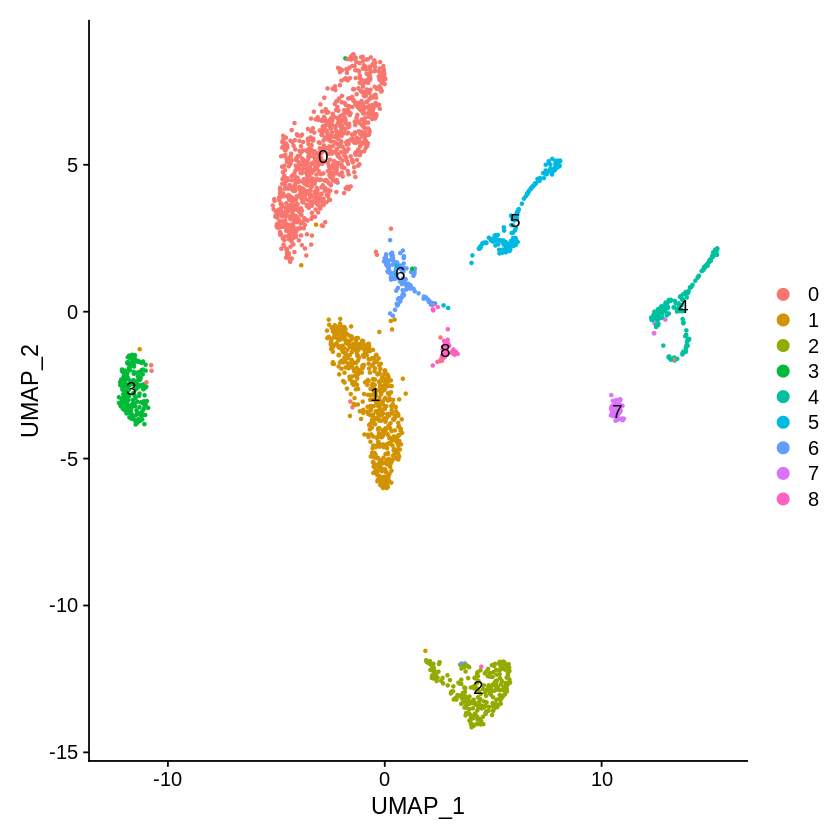

In [21]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [22]:
#ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

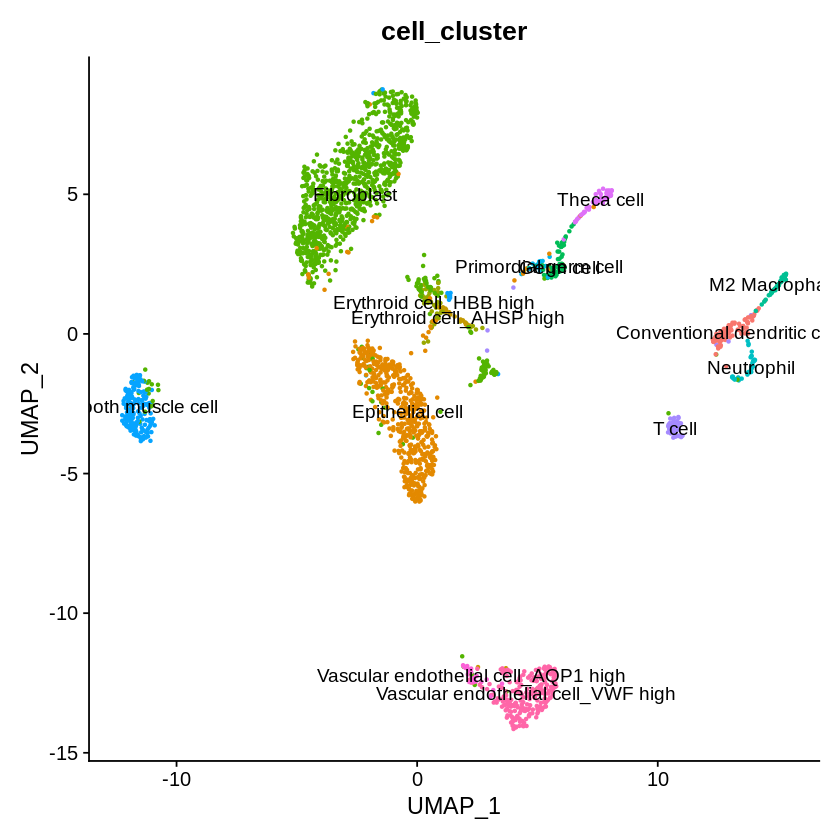

In [23]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster") + NoLegend()
p_umap2

In [24]:
#ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [25]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".__seurat.markers.v1.1.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



In [26]:
new.cluster.ids <- c("Ovary-Connective tissue-Fibroblast-DCN",
                     "Ovary-Epithelial tissue-Epithelial cell-KRT18",
                     "Ovary-Epithelial tissue-Endothelial cell-VWF",
                     "Ovary-Muscle tissue-Smooth muscle cell-ACTA2",
                     "Ovary-Connective tissue-Dendritic cell/Macrophage-CST3/CD14",
                     "Ovary-Connective tissue-Germ cell/Theca cell-PAGE2B/UCHL1",
                     "Ovary-Connective tissue-Erythrocyte-HBB",
                     "Ovary-Connective tissue-T cell-CCL1 CCL2 CCL3",
                     "Ovary-Connective tissue-Germ cell-POU5F1"
                    )
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [27]:
#ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [28]:
#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

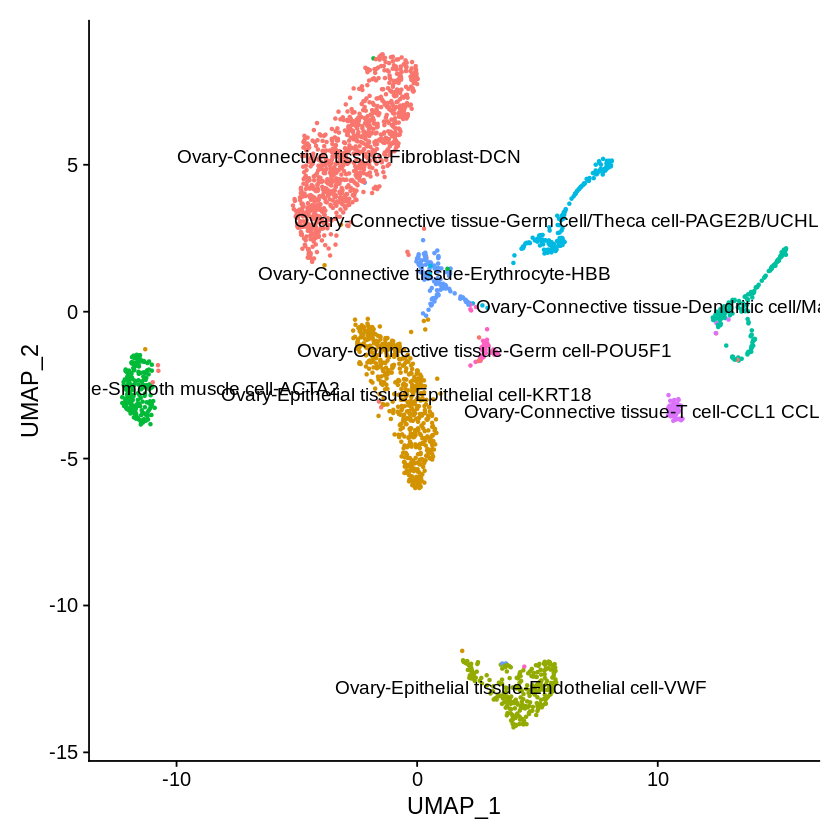

In [29]:
pp_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE)+ NoLegend()
pp_umap2

In [30]:
#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))